import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import numpy as np

Load & Clean

In [2]:
def load_total_generation(path, start_col, end_col):
    # Read CSV, stripping spaces-as-thousands and treating '-' as NaN
    df = pd.read_csv(
        path,
        sep=';',
        thousands=' ',
        na_values='-'
    )
    col_to_drop = df.columns[8]
    df = df.drop(columns=[col_to_drop])
    # Parse the date (first column) to a datetime index
    df['date'] = pd.to_datetime(df.iloc[:, 0], format='%b %d, %Y')
    df.set_index('date', inplace=True)

    # Pull out just the source columns by position
    src = df.iloc[:, start_col:end_col]

    # Clean & convert all those columns
    src = src.replace(',', '', regex=True).astype(float)

    # Convert each to numeric (in case any remain as str)
    src = src.apply(lambda col: pd.to_numeric(col, errors='coerce'))

    # Sum across those numeric columns
    df['TotalGeneration'] = src.sum(axis=1)


    # Return the TotalGeneration series at daily freq
    return df['TotalGeneration'].asfreq('D')

# Example usage:
# If your first column is date, and the next 10 columns are all generation sources,
# then start_col=1, end_col=11
gen = load_total_generation(
    '../data/Actual_generation_202504140000_202504250000_Day.csv',
    start_col=2,
    end_col=12
)

print(gen.head())



date
2025-04-14    1098658.75
2025-04-15    1335042.50
2025-04-16    1113185.00
2025-04-17    1193970.25
2025-04-18     899248.75
Freq: D, Name: TotalGeneration, dtype: float64


In [3]:

def load_cons(path, value_col):
    df = pd.read_csv(path, sep=';')

    # Parse the date in the first column
    df['date'] = pd.to_datetime(df.iloc[:, 0], format='%b %d, %Y')

    # Clean numeric strings:
    #  - Replace '-' with NaN
    #  - Remove commas
    #  - Cast to float
    ser = (df[value_col]
           .replace('-', np.nan)
           .str.replace(',', '')
           .astype(float)
          )

    # Assign the date index (same length as ser)
    ser.index = df['date']

    # Now drop NaNs and enforce daily frequency
    ser = ser.asfreq('D')

    return ser

# Don’t forget the closing parenthesis! 😉
cons = load_cons(
    '../data/Actual_consumption_202504140000_202504250000_Day.csv',
    'grid load [MWh] Calculated resolutions'
)

print(cons.head())


date
2025-04-14    1257666.50
2025-04-15    1316285.50
2025-04-16    1297467.25
2025-04-17    1317192.25
2025-04-18    1074921.75
Freq: D, Name: grid load [MWh] Calculated resolutions, dtype: float64


In [4]:
cons.head()

date
2025-04-14    1257666.50
2025-04-15    1316285.50
2025-04-16    1297467.25
2025-04-17    1317192.25
2025-04-18    1074921.75
Freq: D, Name: grid load [MWh] Calculated resolutions, dtype: float64

In [5]:
def arima_forecast(series, steps=7):
    # Fit on the cleaned series
    model = ARIMA(series, order=(1,1,1)).fit()
    pred = model.get_forecast(steps)
    fc   = pred.predicted_mean
    ci   = pred.conf_int()

    # Build a future date index
    last_date = series.index[-1]
    future_idx = [last_date + timedelta(days=i) for i in range(1, steps+1)]
    fc.index = ci.index = future_idx

    return fc, ci

# Drop the last value (outlier in Consumption) from each series
cons_clean = cons.iloc[:-1]
gen_clean  = gen.iloc[:-1]

# Forecast on the cleaned data
cons_fc, cons_ci = arima_forecast(cons_clean)
gen_fc,  gen_ci  = arima_forecast(gen_clean)


Plotting

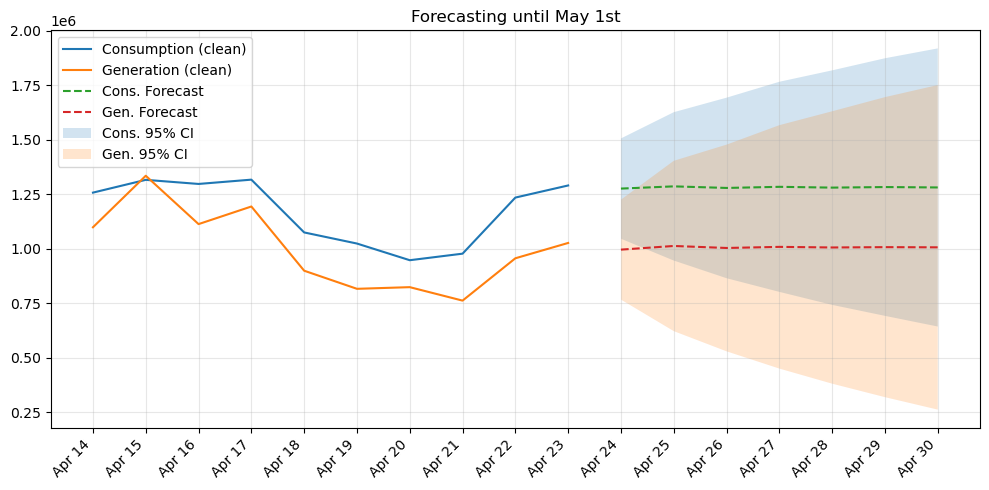

In [ ]:

import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(10,5))
# historical (without the outlier)
ax.plot(cons_clean, label='Consumption (clean)')
ax.plot(gen_clean,  label='Generation (clean)')
# forecasts
ax.plot(cons_fc, '--', label='Cons. Forecast')
ax.plot(gen_fc,  '--', label='Gen. Forecast')
# confidence bands
ax.fill_between(cons_ci.index, cons_ci.iloc[:,0], cons_ci.iloc[:,1],
                alpha=0.2, label='Cons. 95% CI')
ax.fill_between(gen_ci.index,  gen_ci.iloc[:,0],  gen_ci.iloc[:,1],
                alpha=0.2, label='Gen. 95% CI')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(alpha=0.3)
ax.set_title('Forecasting until May 1st')
ax.legend()
plt.tight_layout()
plt.show()
